# Get any graph

In [1]:
# To install library
# !pip install IduEdu

In [11]:
# Get territory boundary
from iduedu import get_4326_boundary

bounds = get_4326_boundary(osm_id=1114252)  # OSM ID for https://www.openstreetmap.org/relation/1114252

In [12]:
# Get drive_graph for boundary
from iduedu import get_drive_graph

G_drive = get_drive_graph(territory=bounds,
                          add_road_category=True,
                          osm_edge_tags=['highway', 'maxspeed', 'reg', 'name', 'lanes', 'ref'],
                          simplify=False)  # Use any of this in additional_edgedata to add it to edges attributes

2025-10-27 17:06:37.736 | INFO     | Downloading drive network via Overpass ...
2025-10-27 17:06:42.676 | WARNING  | Removing 362 nodes from 362 smaller strongly connected components. These are subgraphs where nodes are internally reachable but isolated from the rest. Retaining only the largest strongly connected component (6038 nodes).


In [55]:
# Get walk_graph for boundary
from iduedu import get_walk_graph

G_walk = get_walk_graph(territory=bounds)

2025-10-07 17:12:31.398 | INFO     | Downloading walk network via Overpass ...
2025-10-07 17:12:44.205 | WARNING  | Graph contains 107 weakly connected components. This means the graph has disconnected groups if edge directions are ignored. Component sizes:: [18908, 18, 12, 7, 6, …]
2025-10-07 17:12:44.251 | WARNING  | Removing 274 nodes from 106 smaller strongly connected components. These are subgraphs where nodes are internally reachable but isolated from the rest. Retaining only the largest strongly connected component (18908 nodes).


In [58]:
# Get single or multi type public transport graph for boundary
from iduedu import get_single_public_transport_graph

G_subway = get_single_public_transport_graph(public_transport_type='subway', territory=bounds)


Parsing public transport routes:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
from iduedu import get_all_public_transport_graph

G_public_t = get_all_public_transport_graph(territory=bounds, clip_by_territory=True,
                                            keep_edge_geometry=True)  # clip_by_territory remove all nodes outside the bounds,keep_edge_geometry = False don't save real geometry, to reduce graph size

In [60]:
# Get  multi type public transport graph with custom transports
from iduedu import get_all_public_transport_graph, PublicTrasport

custom_transports = [PublicTrasport.SUBWAY, PublicTrasport.TRAIN]
G_custom_pt = get_all_public_transport_graph(osm_id=421007, clip_by_territory=False, transport_types=custom_transports)

Parsing public transport routes:   0%|          | 0/411 [00:00<?, ?it/s]

In [62]:
# Get intermodal_graph (walk+all_public_transport) for boundary
from iduedu import get_intermodal_graph

G_intermodal = get_intermodal_graph(territory=bounds, clip_by_territory=False)

2025-10-07 17:19:11.193 | INFO     | Downloading walk network via Overpass ...


2025-10-07 17:19:22.432 | WARNING  | HTTP 429: waiting 13 seconds before retry
2025-10-07 17:19:25.931 | WARNING  | Graph contains 107 weakly connected components. This means the graph has disconnected groups if edge directions are ignored. Component sizes:: [18908, 18, 12, 7, 6, …]
2025-10-07 17:19:25.978 | WARNING  | Removing 274 nodes from 106 smaller strongly connected components. These are subgraphs where nodes are internally reachable but isolated from the rest. Retaining only the largest strongly connected component (18908 nodes).
2025-10-07 17:19:37.836 | WARNING  | Waiting 34 seconds for available Overpass API slot


Parsing public transport routes:   0%|          | 0/63 [00:00<?, ?it/s]

2025-10-07 17:20:28.400 | INFO     | Composing intermodal graph...
2025-10-07 17:20:30.919 | WARNING  | Removing 712 nodes from 355 smaller strongly connected components. These are subgraphs where nodes are internally reachable but isolated from the rest. Retaining only the largest strongly connected component (20977 nodes).


In [9]:
from iduedu import join_pt_walk_graph

G_walk_and_subway = join_pt_walk_graph(G_subway,
                                       G_walk)  # use join_pt_walk_graph to compose any public transport graph with walk graph

2025-10-07 16:41:10.035 | INFO     | Composing intermodal graph...
2025-10-07 16:41:12.752 | WARNING  | Removing 47 nodes from 47 smaller strongly connected components. These are subgraphs where nodes are internally reachable but isolated from the rest. Retaining only the largest strongly connected component (19108 nodes).


In [23]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import contextily as ctx
import geopandas as gpd

EDGE_COLORS = {
    "walk": "#72B7B2",
    "boarding": "#9A9A9A",
    "bus": "#4C78A8",
    "trolleybus": "#F58518",
    "tram": "#E45756",
    "subway": "#2E7D32",
}
FALLBACK = "#444444"

territory3857 = gpd.GeoDataFrame(geometry=[bounds], crs=4326).to_crs(3857)

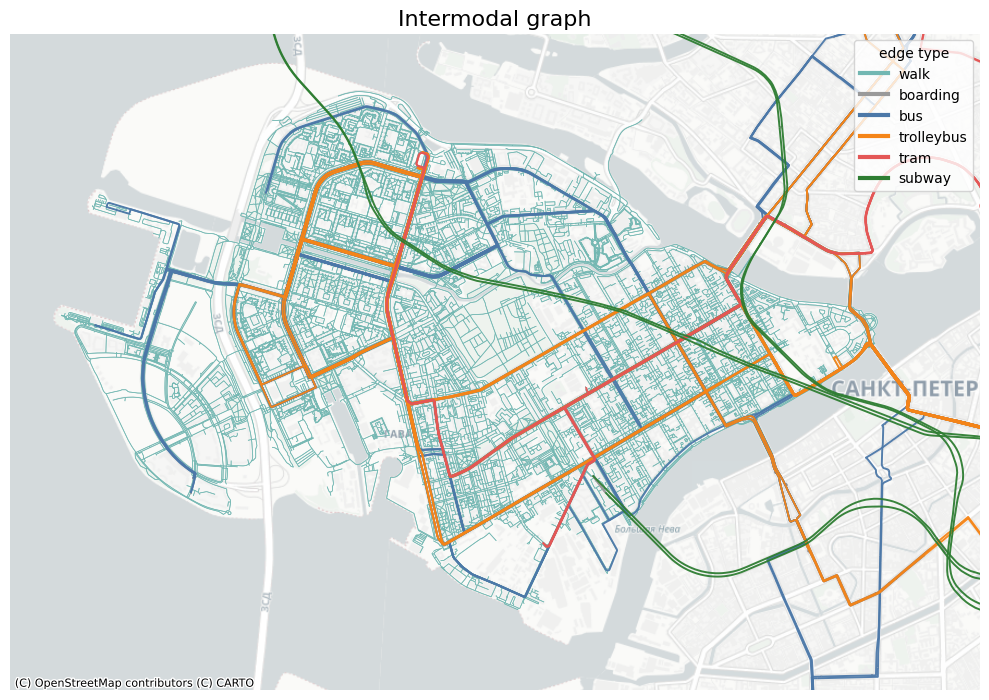

In [24]:
from iduedu import graph_to_gdf

G_intermodal_gdf = graph_to_gdf(G_intermodal, nodes=False, restore_edge_geom=True)
fig, ax = plt.subplots(figsize=(10, 10))
minx, miny, maxx, maxy = territory3857.total_bounds
dx, dy = (maxx - minx) * 0.05, (maxy - miny) * 0.05
ax.set_xlim(minx - dx, maxx + dx)
ax.set_ylim(miny - dy, maxy + dy)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
legend_handles = []
present = set(G_intermodal_gdf["type"])
for t in [t for t in EDGE_COLORS if t in present]:
    sub = G_intermodal_gdf[G_intermodal_gdf["type"] == t].to_crs(3857)
    if sub.empty:
        continue
    color = EDGE_COLORS.get(t, FALLBACK)
    sub.plot(ax=ax, color=color, linewidth=0.5 if t == 'walk' else 1.4, alpha=0.95)
    legend_handles.append(Line2D([0], [0], color=color, lw=3, label=t))
if legend_handles:
    ax.legend(handles=legend_handles, loc="upper right", frameon=True, title="edge type")
ax.set_axis_off()
ax.set_title("Intermodal graph", fontsize=16)
plt.tight_layout()
plt.show()

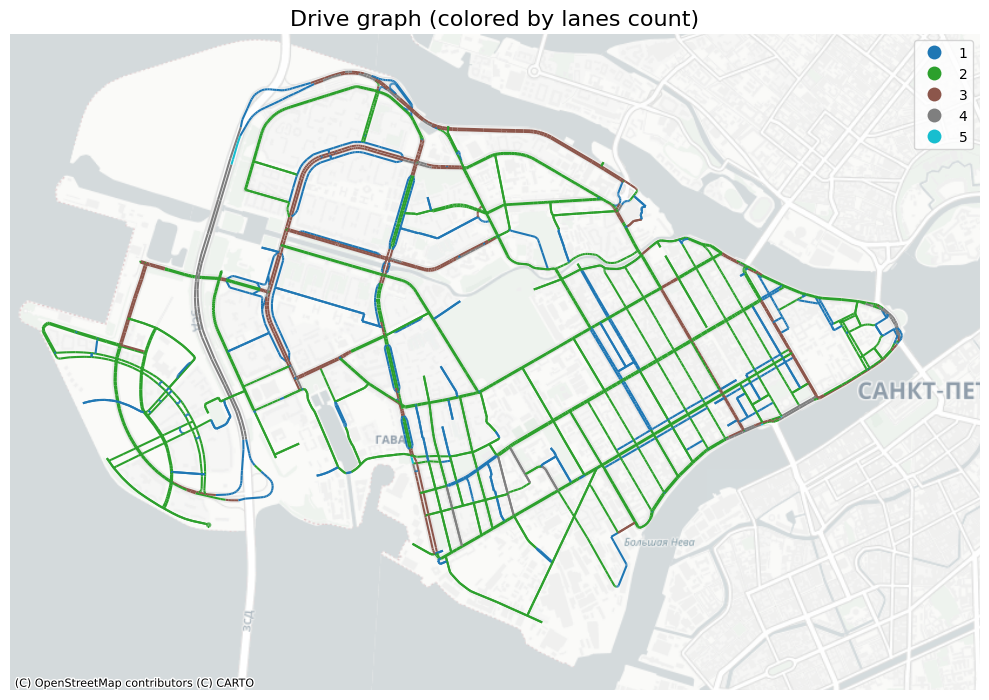

In [38]:
from iduedu import graph_to_gdf

G_drive_gdf = graph_to_gdf(G_drive, nodes=False, restore_edge_geom=True)
fig, ax = plt.subplots(figsize=(10, 10))
minx, miny, maxx, maxy = territory3857.total_bounds
dx, dy = (maxx - minx) * 0.01, (maxy - miny) * 0.01
ax.set_xlim(minx - dx, maxx + dx)
ax.set_ylim(miny - dy, maxy + dy)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
G_drive_gdf['lanes'] = G_drive_gdf['lanes'].fillna(1).astype(int)
G_drive_gdf.to_crs(3857).plot(ax=ax, column='lanes', legend=True, categorical=True)
ax.set_axis_off()
ax.set_title("Drive graph (colored by lanes count)", fontsize=16)
plt.tight_layout()
plt.show()

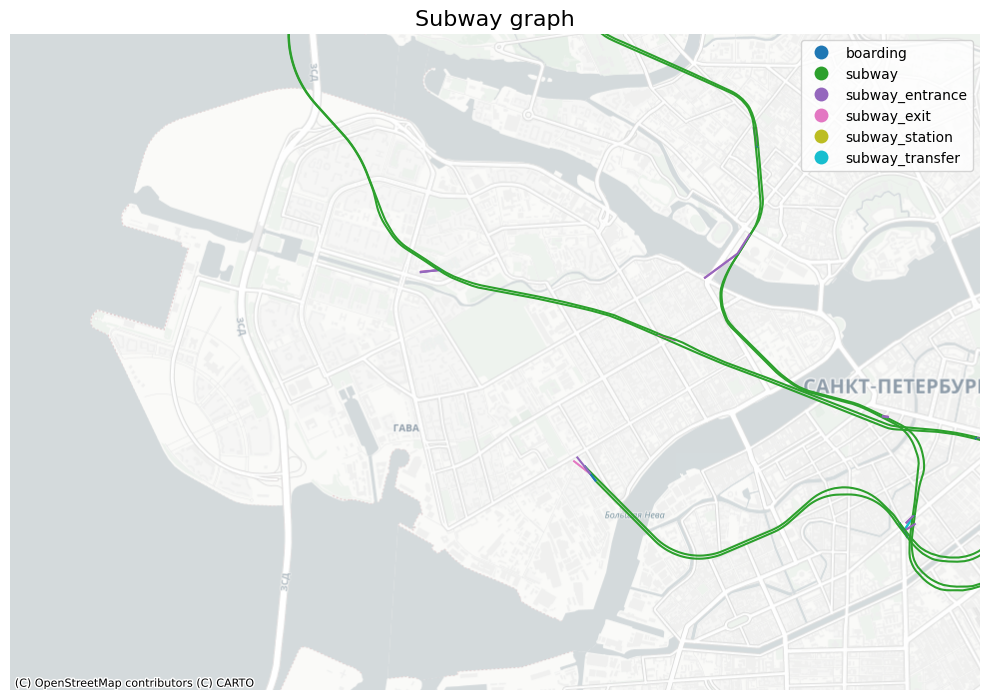

In [44]:
from iduedu import graph_to_gdf

G_subway_gdf = graph_to_gdf(G_subway, nodes=False, restore_edge_geom=True)
fig, ax = plt.subplots(figsize=(10, 10))
minx, miny, maxx, maxy = territory3857.total_bounds
dx, dy = (maxx - minx) * 0.1, (maxy - miny) * 0.1
ax.set_xlim(minx - dx, maxx + dx)
ax.set_ylim(miny - dy, maxy + dy)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
G_subway_gdf.to_crs(3857).plot(ax=ax, column='type', legend=True)
ax.set_axis_off()
ax.set_title("Subway graph", fontsize=16)
plt.tight_layout()
plt.show()

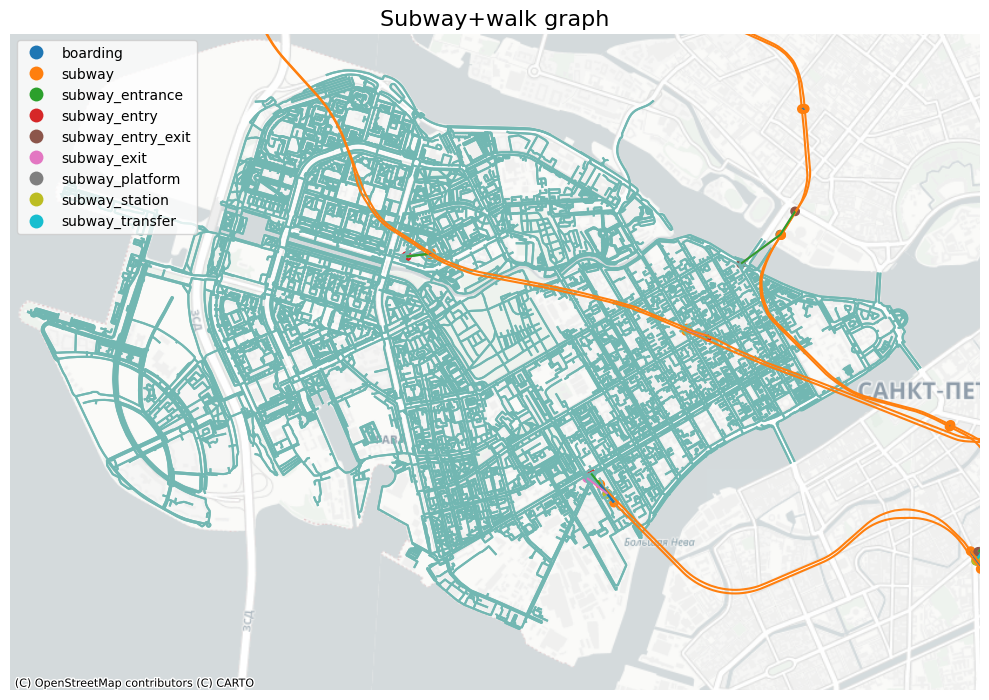

In [51]:
from iduedu import graph_to_gdf

G_custom_pt_gdf = graph_to_gdf(G_walk_and_subway, restore_edge_geom=True)
fig, ax = plt.subplots(figsize=(10, 10))
minx, miny, maxx, maxy = territory3857.total_bounds
dx, dy = (maxx - minx) * 0.01, (maxy - miny) * 0.01
ax.set_xlim(minx - dx, maxx + dx)
ax.set_ylim(miny - dy, maxy + dy)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
G_custom_pt_gdf[G_custom_pt_gdf['type'] == 'walk'].to_crs(3857).plot(ax=ax, color=EDGE_COLORS['walk'])
G_custom_pt_gdf[G_custom_pt_gdf['type'] != 'walk'].to_crs(3857).plot(ax=ax, column='type', legend=True)
ax.set_axis_off()
ax.set_title("Subway+walk graph", fontsize=16)
plt.tight_layout()
plt.show()